In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [2]:
cpu_count = mp.cpu_count()
print(cpu_count)

16


In [3]:
# Train-test split

data_path = "data/"

In [4]:
image_fns = os.listdir(data_path)
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

1070
[5]


In [5]:
for idx, image_fn in enumerate(image_fns):
    if len(image_fn.split(".")[0]) != 5:
        print(image_fn)

In [6]:
image_fns_train, image_fns_test = train_test_split(image_fns,random_state=0)
print(len(image_fns_train), len(image_fns_test))

802 268


In [7]:
# Define character maps

image_ns = [image_fn.split(".")[0] for image_fn in image_fns]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

19
['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [8]:
vocabulary = ["-"] + letters 
print(len(vocabulary))
print(vocabulary)
# 캐릭터 맵 정의
idx2char = {k:v for k,v in enumerate(vocabulary,start=0)}
print(idx2char)

# 역으로 캐릭터 맵 변환
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)


20
['-', '2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']
{0: '-', 1: '2', 2: '3', 3: '4', 4: '5', 5: '6', 6: '7', 7: '8', 8: 'b', 9: 'c', 10: 'd', 11: 'e', 12: 'f', 13: 'g', 14: 'm', 15: 'n', 16: 'p', 17: 'w', 18: 'x', 19: 'y'}
{'-': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5, '7': 6, '8': 7, 'b': 8, 'c': 9, 'd': 10, 'e': 11, 'f': 12, 'g': 13, 'm': 14, 'n': 15, 'p': 16, 'w': 17, 'x': 18, 'y': 19}


In [9]:
# Define data loader

batch_size = 16

In [10]:
class CAPTCHADataset(Dataset):
    def __init__(self,data_dir,image_fns):
        self.data_dir = data_dir
        self.image_fns = image_fns

    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self,index):
        # 이미지 파일명
        image_fn = self.image_fns[index]
        # 이미지 파일 경로
        image_fp = os.path.join(self.data_dir,image_fn)
        # 이미지 파일 열기
        image = Image.open(image_fp).convert("RGB")
        # 이미지를 변환
        image = self.transforms(image)
        # 이미지 파일명에서 라벨 추출
        text = image_fn.split(".")[0]
        return image, text
        
    def transforms(self, image):        
        # transforms.Compose : Transform에 여러 단계가 존재하는 경우 하나로 묶어주는 역할
        # transforms에 속한 함수들을 compose를 통해 묶어 한번에 처리 가능
        transform_ops = transforms.Compose([
            # 텐서로 변환
            transforms.ToTensor(),
            # 정규화
            transforms.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225))
        ])

        return transform_ops(image)


In [11]:

# 데이터셋 정의
trainset = CAPTCHADataset(data_path,image_fns_train)
testset = CAPTCHADataset(data_path,image_fns_test)

# 데이터 로더 정의
# 불러온 데이터셋을 순회할 수 있도록 해줌
train_loader = DataLoader(trainset,batch_size=batch_size,num_workers=0,shuffle=True)
test_loader = DataLoader(testset,batch_size=batch_size,num_workers=0,shuffle=False)


print(len(train_loader), len(test_loader))

51 17


In [12]:
# 배치 사이즈만큼 데이터를 불러옴

image_batch, text_batch = next(iter(train_loader))
print(image_batch.size(),text_batch)

torch.Size([16, 3, 50, 200]) ('wnpec', '43p5d', 'mc35n', 'bd3b7', 'g55b4', 'dw8d3', 'eppg3', 'fcne6', 'nwncn', 'xe8xm', 'cd4eg', 'yemy4', 'c8n8c', '43gey', 'bm3p8', 'bw5nf')


In [13]:
# Define model

num_chars = len(char2idx)
print(num_chars)
# RNN의 은닉층 수
rnn_hidden_size = 256

20


In [14]:
# 쿠다 사용
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [15]:

# resnet 모델 불러오기
# Resnet모델은 2015년 마이크로소프트에서 개발한 CNN모델
# Resnet18은 18개의 레이어로 구성된 모델
resnet = resnet18(pretrained=True)

d:\Tiz\data-vaoucher\recapha\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Tiz\data-vaoucher\recapha\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
class CRNN(nn.Module):
    # nn.Module을 상속받아 모델 생성
    # nn.Module은 모든 신경망 모듈의 기본이 되는 클래스

    # Args:
    # num_chars: 캐릭터 맵의 길이
    # rnn_hidden_size: RNN의 은닉층 수
    # drop_out: 드롭아웃 비율

    def __init__(self, num_chars,rnn_hidden_size=256,dropout=0.1):
        # super()를 통해 nn.Module의 생성자를 호출
        super(CRNN,self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout

        # CNN Part1

        # resnet의 마지막 레이어를 제외한 모든 레이어를 가져옴
        resnet_modules = list(resnet.children())[:-3]
        # cnn_p1에 resnet의 모든 레이어를 저장
        self.cnn_p1 = nn.Sequential(*resnet_modules)

        # CNN Part2
        self.cnn_p2 = nn.Sequential(
            # Conv2d : 2차원 컨볼루션 레이어
            # in_channels : 입력 채널 수
            # out_channels : 출력 채널 수
            # kernel_size : 커널 크기
            # stride : 스트라이드 -> 커널이 이동하는 간격
            # padding : 패딩 크기            
            nn.Conv2d(256,256,kernel_size=(3,6),stride=1,padding=1),
            # BatchNorm2d : 2차원 배치 정규화
            # 정규화 : 데이터를 평균 0, 분산 1로 만들어 학습이 잘 일어나도록 돕는 방법
            nn.BatchNorm2d(256),
            # ReLU : 활성화 함수 
            # ReLU : 입력값이 0보다 작으면 0, 0보다 크면 입력값 그대로 출력
            # inplace : 입력값을 직접 변경할지 여부
            nn.ReLU(inplace=True),
        )
        # Linear : 선형 레이어
        # 이 레이어는 입력과 출력을 모두 연결해주는 역할

        self.linear1 = nn.Linear(1024,256)

        # RNN

        # GRU : Gated Recurrent Unit
        # 순차 데이터를 처리하는 RNN의 일종
        # Reset Gate와 Update Gate를 사용해 순차 데이터를 처리
        # Reset Gate : 이전 시점의 정보를 얼마나 반영할지 결정
        # Update Gate : 현재 시점의 정보를 얼마나 반영할지 결정

        
        self.rnn1 = nn.GRU(
            # 입력 채널 수
            input_size=rnn_hidden_size,
            # 은닉층 수 (RNN의 은닉층 수) 
            # 은닉층이란 입력층과 출력층 사이에 존재하는 중간층으로서, 입력층과 출력층의 연결을 담당하는 노드의 집합
            hidden_size=rnn_hidden_size,
            # bidirectional : 양방향 RNN 사용 여부
            # 양방향 RNN은 입력 데이터를 앞에서부터 읽는 것과 뒤에서부터 읽는 것 두 가지로 나누어 읽음
            bidirectional=True,
            # batch_first : 배치 사이즈를 첫번째 차원으로 설정
            batch_first=True,
        )
        # rnn2는 rnn1과 동일한 설정
        # 두개의 rnn을 사용하면 더 정확한 예측이 가능
        self.rnn2 = nn.GRU(
            input_size=rnn_hidden_size,
            hidden_size=rnn_hidden_size,
            bidirectional=True,
            batch_first=True,
        )

        self.linear2 = nn.Linear(self.rnn_hidden_size*2,num_chars)

    def forward(self,batch:torch.Tensor):
        # forward 함수는 모델이 학습 데이터를 입력받아 순전파 연산을 진행시키는 함수


        batch = self.cnn_p1(batch)

        batch = self.cnn_p2(batch)

        # permute : 텐서의 차원을 변경
        # 왜 텐서의 차원을 변경하는가? -> RNN에 입력하기 위해
        # RNN은 입력 데이터의 차원이 (배치 사이즈, 시퀀스 길이, 입력 채널 수)로 고정되어 있음
        batch = batch.permute(0,3,1,2)

        # batch_size : 배치 사이즈
        batch_size = batch.size(0)
        # T: 시퀀스 길이
        # 시퀀스는 순서가 있는 데이터의 집합
        T = batch.size(1)
        # view : 텐서의 차원을 변경
        # view(batch_size,T,-1) : 배치 사이즈와 시퀀스 길이는 그대로 유지하고 나머지 차원을 -1로 설정
        # 차원을 -1로 설정하면 텐서의 크기가 자동으로 계산됨 -> 즉, 텐서의 크기를 자동으로 계산하라는 의미
        # [batch_size, T==width, num_features==channels*height] 
        batch = batch.view(batch_size,T,-1)

        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [17]:
def weights_init(m):
    # weights_init 함수는 모델의 레이어의 가중치를 초기화하는 함수
    # 가중치를 초기화시키는 이유는 모델의 성능을 높이기 위함
    # m : 모델의 레이어

    classname = m.__class__.__name__
    # m.__class__.__name__ : 모델의 레이어의 이름을 가져옴

    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        # xavier_uniform_ : 가중치를 균등 분포로 초기화
        # 균등 분포란? : 모든 구간에서 동일한 확률을 가지는 분포
        torch.nn.init.xavier_uniform_(m.weight)
        # m.bias.data.fill_(0.01) : 편향을 0.01로 초기화
        if m.bias is not None:
            # 편향이 None이 아니면
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        # BatchNorm 레이어의 경우
        # m.weight.data.normal_(1.0, 0.02) : 가중치를 정규 분포로 초기화
        # 정규 분포란? : 평균과 표준편차를 가지는 분포         
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
# 모델 생성
crnn = CRNN(num_chars,rnn_hidden_size=rnn_hidden_size)
# 모델의 가중치 초기화
crnn.apply(weights_init)
# 모델을 쿠다에 할당
crnn = crnn.to(device)

In [19]:
# logits : 모델의 출력값
text_batch_logits = crnn(image_batch.to(device))

print(text_batch)
print(text_batch_logits.shape)

('wnpec', '43p5d', 'mc35n', 'bd3b7', 'g55b4', 'dw8d3', 'eppg3', 'fcne6', 'nwncn', 'xe8xm', 'cd4eg', 'yemy4', 'c8n8c', '43gey', 'bm3p8', 'bw5nf')
torch.Size([10, 16, 20])


In [20]:
# 손실 함수 정의
# 손실함수란, 모델의 출력값과 실제값의 차이를 계산하는 함수
# 손실 함수의 값이 작을수록 모델의 성능이 좋음

# CTC Loss : Connectionist Temporal Classification Loss
# CTC Loss는 음성 인식, 문자 인식 등의 문제에서 사용되는 손실 함수
criterion = nn.CTCLoss(blank=0)

In [21]:
def encode_text_batch(text_batch):
    # encode_text_batch 함수는 텍스트 배치를 인코딩하는 함수
    
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [22]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    # compute_loss 함수는 손실 함수를 계산하는 함수
    
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [23]:
compute_loss(text_batch, text_batch_logits)

tensor(4.3772, device='cuda:0', grad_fn=<MeanBackward0>)

In [24]:
# 모델 학습

# 학습 횟수
num_epochs = 50 
# 학습률이란, 모델이 학습할 때 가중치를 얼마나 빠르게 업데이트할지를 결정하는 하이퍼파라미터
lr = 0.001
# weight_decay란, 모델의 가중치가 커지는 것을 방지하기 위해 가중치를 감소시키는 하이퍼파라미터
# 1e-3 : 0.001
weight_decay = 1e-3
# clip_norm이란, 그래디언트 폭주를 방지하기 위해 그래디언트를 잘라내는 하이퍼파라미터
# 그레디언트 폭주란, 그래디언트가 너무 커져서 모델의 가중치가 발산하는 현상
# 그레디언트란, 손실 함수의 값이 작아지도록 모델의 가중치를 업데이트하는 방향을 결정하는 값
clip_norm = 5

In [25]:
# 옵티마이저 정의
# optimizer: 모델의 가중치를 업데이트하는 방법을 결정하는 하이퍼파라미터

# Adam : 모멘텀과 RMSProp을 합친 것 
# Momentum : 매개변수의 이동에 속도를 부여하는 것
    # 구슬을 떨어트리면 급한 경사에서 빠르게 굴러가듯이 매개변수의 변화에도 속도를 부여
    # SGD(Stochastic Gradient Descent, 확률적 경사 하강법)의 단점을 보완
# RMSProp : 모델의 관성을 줄이기 위해 모델의 가중치를 업데이트할 때 관성을 줄이는 방법
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
# 스케줄러 정의
# 스케줄러란, 학습률을 조절하는 하이퍼파라미터
# ReduceLROnPlateau : 학습률을 조절하는 방법 중 하나
ls_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True,patience=5)


In [109]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []

for epoch in tqdm(range(1, num_epochs+1)):
    # epoch_loss_list : 에폭당 손실 함수의 값들을 저장하는 리스트
    epoch_loss_list = [] 
    # num_updates_epoch : 에폭당 업데이트 횟수
    num_updates_epoch = 0

    for image_batch, text_batch in tqdm(train_loader, leave=False):
        # 이 for문은 배치 사이즈만큼 데이터를 불러오는 for문
        # optimizer.zero_grad() : 옵티마이저의 그래디언트를 0으로 초기화
        optimizer.zero_grad()
        # text_batch_logits : 모델의 출력값        
        text_batch_logits = crnn(image_batch.to(device))
        # compute_loss 함수를 통해 손실 함수를 계산
        loss = compute_loss(text_batch, text_batch_logits)
        # loss.item() : 손실 함수의 값
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            # iteration_loss가 nan이거나 inf이면 
            continue
          
        # 에폭당 업데이트 증가
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        
        epoch_loss_list.append(iteration_loss)
        # backward() : 손실 함수의 값에 대한 그래디언트를 계산
        loss.backward()
        # clip_grad_norm_ : 그래디언트 폭주를 방지하기 위해 그래디언트를 잘라냄
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        # optimizer.step() : 옵티마이저를 통해 모델의 가중치를 업데이트
        optimizer.step()
    # 에폭당 손실 함수의 값들의 평균을 계산
    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    # 에폭당 손실 함수의 값들을 저장
    epoch_losses.append(epoch_loss)
    # 에폭당 업데이트 횟수를 저장
    num_updates_epochs.append(num_updates_epoch)
    # ls_scheduler.step : 스케줄러를 통해 학습률을 조절
    ls_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:1    Loss:0.006118684751438159    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:2    Loss:0.005819600488643582    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:3    Loss:0.005672229079566165    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:4    Loss:0.00555372470761558    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:5    Loss:0.005437294315711102    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:6    Loss:0.005322005512996339    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:7    Loss:0.005202848886541438    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:8    Loss:0.0050594075582921505    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:9    Loss:0.004900647998403977    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:10    Loss:0.004736868420378396    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:11    Loss:0.004573628840529744    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:12    Loss:0.004426066336842875    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:13    Loss:0.004332820775316042    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:14    Loss:0.0042687449421660575    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:15    Loss:0.0041964485278060916    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:16    Loss:0.007326701797508434    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:17    Loss:0.015292009836354968    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:18    Loss:0.011282777358942172    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:19    Loss:0.009184647054758435    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:20    Loss:0.007983527210194106    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:21    Loss:0.004438203896450645    NumUpdates:51
Epoch 00071: reducing learning rate of group 0 to 1.0000e-05.


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:22    Loss:0.00369445002391277    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:23    Loss:0.0035547763154860222    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:24    Loss:0.003524503120513377    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:25    Loss:0.00350427527583259    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:26    Loss:0.003489594046008207    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:27    Loss:0.0034780850743546207    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:28    Loss:0.0034689589942275894    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:29    Loss:0.0034618574130695825    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:30    Loss:0.0034558938761406087    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:31    Loss:0.0034512277080805277    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:32    Loss:0.0034472677975381704    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:33    Loss:0.0034441518798178318    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:34    Loss:0.003441894139327547    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:35    Loss:0.0034403071359859084    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:36    Loss:0.003439385268161548    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:37    Loss:0.003439136922322944    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:38    Loss:0.003439122934223098    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:39    Loss:0.003439688712687177    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:40    Loss:0.003440593821270501    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:41    Loss:0.003441570541255322    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:42    Loss:0.003442715832908802    NumUpdates:51
Epoch 00092: reducing learning rate of group 0 to 1.0000e-06.


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:43    Loss:0.003422525026561583    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:44    Loss:0.0034227754108096453    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:45    Loss:0.003422983584231606    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:46    Loss:0.0034231402404496774    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:47    Loss:0.003423359473327211    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:48    Loss:0.0034235916739585354    NumUpdates:51


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:49    Loss:0.0034238467878643787    NumUpdates:51
Epoch 00099: reducing learning rate of group 0 to 1.0000e-07.


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch:50    Loss:0.003421670857670845    NumUpdates:51


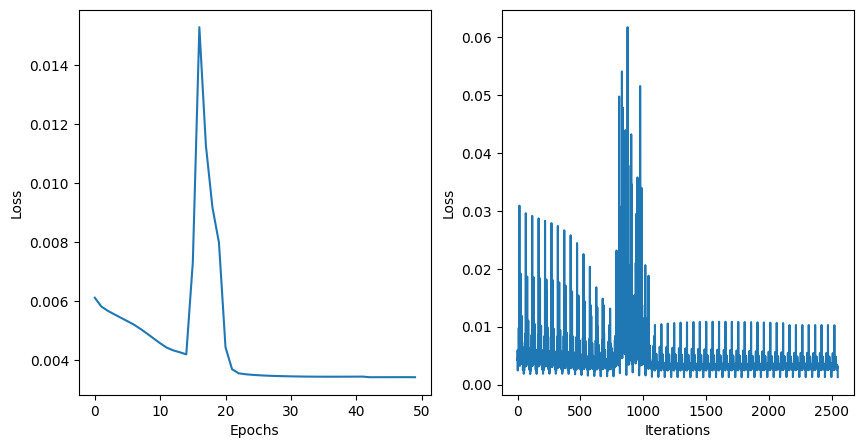

In [110]:
# 통계 시각화

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

In [111]:
def decode_predictions(text_batch_logits):
    # decode_predictions 함수는 모델의 출력값을 디코딩하는 함수
    # 디코딩이란, 모델의 출력값을 실제값으로 변환하는 것

    # F.softmax(text_batch_logits, 2) : 모델의 출력값을 확률로 변환
    text_batch_tokens = F.log_softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    # text_batch_tokens : 모델의 출력값을 확률로 변환한 것을 가장 큰 값의 인덱스로 변환
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [112]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/51 [00:00<?, ?it/s]

In [113]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/17 [00:00<?, ?it/s]

In [114]:
print(results_train.shape)
results_train.head()

(802, 2)


,actual,prediction
0,6n6gg,6n----6g-g
1,ddcne,dd---dcn-e
2,mgw3n,mg----w3-n
3,4ycex,4y----ce-x
4,x6b5m,x6----b5-m


In [115]:
print(results_test.shape)
results_test.head()

(268, 2)


,actual,prediction
0,w4cdc,w4----cd-c
1,n4xx5,n4----xx-5
2,e76n4,e7----6n-4
3,ddcdd,dd--d-cd-d
4,bbymy,bb----ym-y


In [120]:
def remove_duplicates(text):
    # remove_duplicates 함수는 중복된 문자를 제거하는 함수
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    # correct_prediction 함수는 예측값을 수정하는 함수
    parts = word.split("-")
    # parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word


In [121]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,6n6gg,6n----6g-g,6n6gg
1,ddcne,dd---dcn-e,dddcne
2,mgw3n,mg----w3-n,mgw3n
3,4ycex,4y----ce-x,4ycex
4,x6b5m,x6----b5-m,x6b5m


In [122]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,w4cdc,w4----cd-c,w4cdc
1,n4xx5,n4----xx-5,n4xx5
2,e76n4,e7----6n-4,e76n4
3,ddcdd,dd--d-cd-d,dddcdd
4,bbymy,bb----ym-y,bbymy


In [123]:
# 모델 평가

mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
3,ddcdd,dd--d-cd-d,dddcdd
14,emwpn,em-----wpp,emwpp
16,x76mn,x7----6mmn,x76mmn
30,m3wfw,m33----wfw,m33wfw
34,cwmny,cw-----m-n,cwmn
36,nmy2x,nm----yy2x,nmyy2x
42,d4ppy,d4---4pp-y,d44ppy
44,7bwm2,7b----wmm2,7bwmm2
47,85622,85--5-62-2,855622
48,mp7wp,mg-----7w-,mg7w


In [124]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

prediction_corrected
6    33
5     5
4     3
7     1
Name: count, dtype: int64


In [125]:
mask = mistakes_df['prediction_corrected'].str.len() == 5
mistakes_df[mask]

,actual,prediction,prediction_corrected
14,emwpn,em-----wpp,emwpp
83,n3ffn,n3----ff-f,n3fff
99,5x7x5,6x----7x-5,6x7x5
134,4m2w5,5m-----2w5,5m2w5
183,my84e,mw-----84e,mw84e


data/emwpn.png


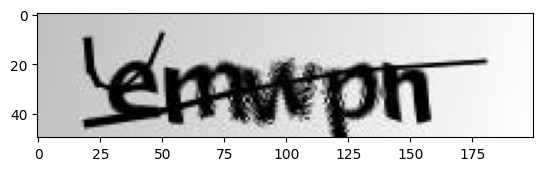

In [126]:
mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
print(mistake_image_fp)
mistake_image = Image.open(mistake_image_fp)
plt.imshow(mistake_image)
plt.show()

In [127]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.8204488778054863
0.8432835820895522


In [46]:
# 학습한 모델 저장
torch.save(crnn.state_dict(), "crnn.pt")

In [74]:
# 저장한 모델을 불러와서 사용

model = CRNN(num_chars,rnn_hidden_size=rnn_hidden_size)
model.load_state_dict(torch.load("crnn.pt"))
model.eval()

model.to(device)


CRNN(
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [75]:
def transform(image):
    transform_ops = transforms.Compose([
        # 텐서로 변환
        transforms.ToTensor(),
        # 정규화
        transforms.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225))
    ])
    return transform_ops(image)

In [103]:
# 모델을 사용하는 프로세스
# 1. 특정 이미지 가져오기
# 2. 이미지를 텐서로 변환 (쿠다에 할당)
# 3. 모델을 forward로 돌린 후 
# 4. 모델의 출력값을 디코딩
    # 디코딩 과정은 모델의 출력값을 확률로 변환 후 가장 큰 값의 인덱스로 변환
    # 예) [0.1, 0.2, 0.7] -> [0, 0, 1] -> "C"


inputs = transform(Image.open("data/22d5n.png").convert("RGB"))
# 쿠다
inputs = inputs.to(device)
# 모델 실행
outputs = model(inputs.unsqueeze(0))

decoded_outputs = decode_predictions(outputs.cpu())

print(decoded_outputs)


['22----d5-n']
